In [887]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
np.random.seed(1000)

In [888]:
file_path = "S_plasample_cube_40.txt"
datasets = []
current_dataset = []
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith("#Parameters"):
            if current_dataset:
                datasets.append(current_dataset)
                current_dataset = []
            params_str = line[line.index("{")+1:line.index("}")]
            params = dict(param.split('=') for param in params_str.split(';'))
            current_dataset.append(params)
        elif line.startswith("#"):
            continue
        else:
            data = line.strip().split('\t')
            current_dataset.append(data)
if current_dataset:
    datasets.append(current_dataset)
for i, dataset in enumerate(datasets):
    permittivity_values = dataset[0]
    df_data = dataset[1:]
    df = pd.DataFrame(df_data, columns=["Frequency", "Real", "Imaginary"])
    print(f"Dataset {i+1} - Permittivity values:")
    for key, value in permittivity_values.items():
        print(f"{key}: {value}")
    print("Data:")
    print(df)
    print()

Dataset 1 - Permittivity values:
vshift: -21.275
 cc: 40
 bb: 40
 aa: 40
 erpla1: 0.0041269841269841
 erpla: 3.15
 L1: 67
 L2: 32
 L22: 60
 L3: 34.5
 a1: -110.3314
 a2: 110.3314
 b1: -28.048
 b2: 110.3821
 c1: 0
 c2: 11.9761
 d1: -82.55
 d2: 82.55
 e1: 0
 e2: 82.3341
 er1: 2.55
 er11: 2.55
 h1: 14
 h22: 14
 h33: 28.5
 r0: 10.38125
 r00: 13
 r1: 8.001
 r11: 10.5
 r2: 2.09
 r22: 4.5
 r3: 7.653
 r33: 17
 r44: 2.75
 th1: 4.7625
 th11: 4.7625
 th2: 4.7625
 umax: 82.55
 umin1: -87.3125
 umin2: -82.55
 vmax: 87.0966
 vmin: 82.55
 vmin1: -4.7625
 vmin2: 87.0966
 wmax: 138.1125
 wx: 165.1
 wx2: 220.662
 wx_2: 174.625
 wx_21: 220.6628
 wx_22: 165.1
 wy: 82.55
 wy2: 138.43
 wy_2: 91.8591
 wy_21: 138.4301
 wy_22: 82.3341
 wz: 1000
 wz2: 12
 wz_2: 209.55
 wz_21: 14
 wz_22: 204.01
 zshift: 101
 zshift1: 154
Data:
            Frequency                Real          Imaginary
0     1.0000000000000  -0.079316847026348   0.32380053400993
1     1.0010000467300  -0.065709270536900   0.32323741912842
2     

In [889]:
mat = scipy.io.loadmat('data.mat')
out_data = mat['out_data']
df = pd.DataFrame(out_data)
df.columns = ['frequency','permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']
print(df.head(20))

    frequency  permittivity_real  permittivity_imaginary  s11_real   
0       1.199           2.572762                0.064912 -0.003002  \
1       1.199           3.008671                0.073172 -0.003481   
2       1.199           5.928357                0.064775 -0.006756   
3       1.199           4.786311                0.045092 -0.006433   
4       1.199           3.813276                0.054701 -0.005164   
5       1.199           7.646629                0.029632 -0.008666   
6       1.199           5.682113                0.074469 -0.006294   
7       1.199           5.397789                0.018896 -0.007740   
8       1.199           8.337549                0.068678 -0.007830   
9       1.199           3.286712                0.018351 -0.005592   
10      1.199           7.057602                0.036848 -0.008175   
11      1.199           7.029833                0.062562 -0.007415   
12      1.199           4.043567                0.078023 -0.004763   
13      1.199       

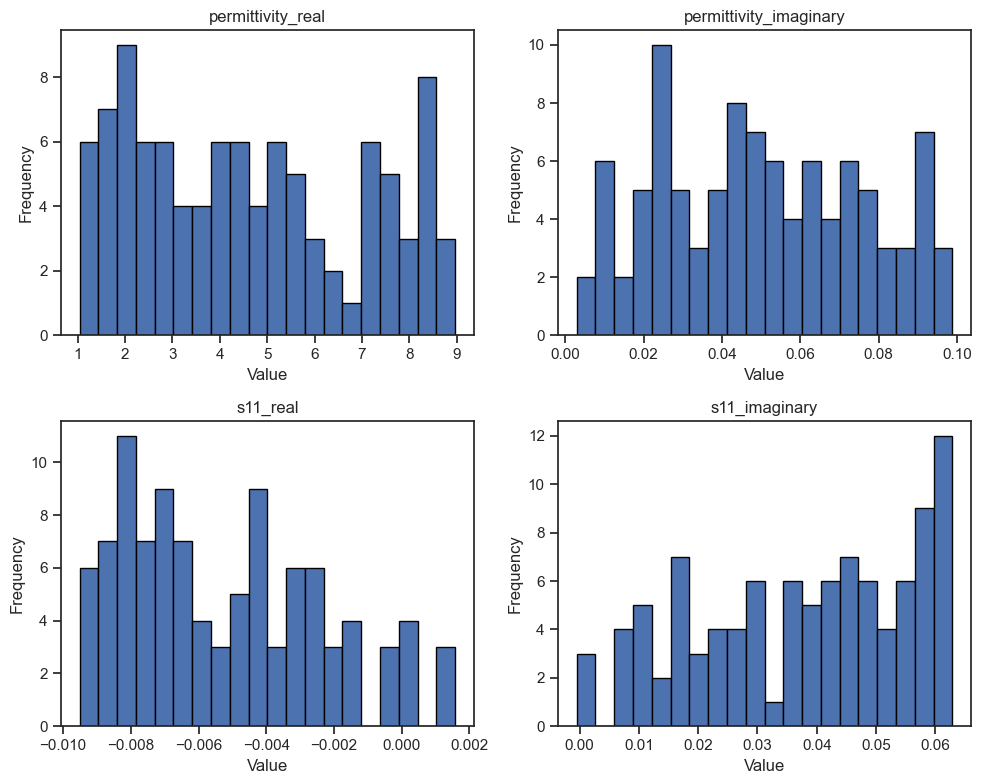

In [890]:
columns = ['permittivity_real', 'permittivity_imaginary', 's11_real', 's11_imaginary']
plt.figure(figsize=(10, 8))
for i, column in enumerate(columns):
    plt.subplot(2, 2, i+1)
    plt.hist(df[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

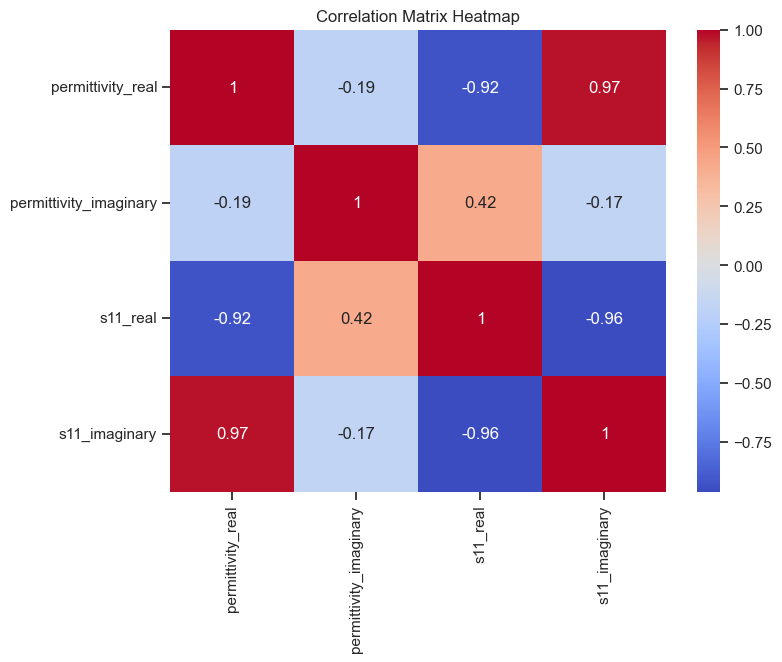

In [891]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

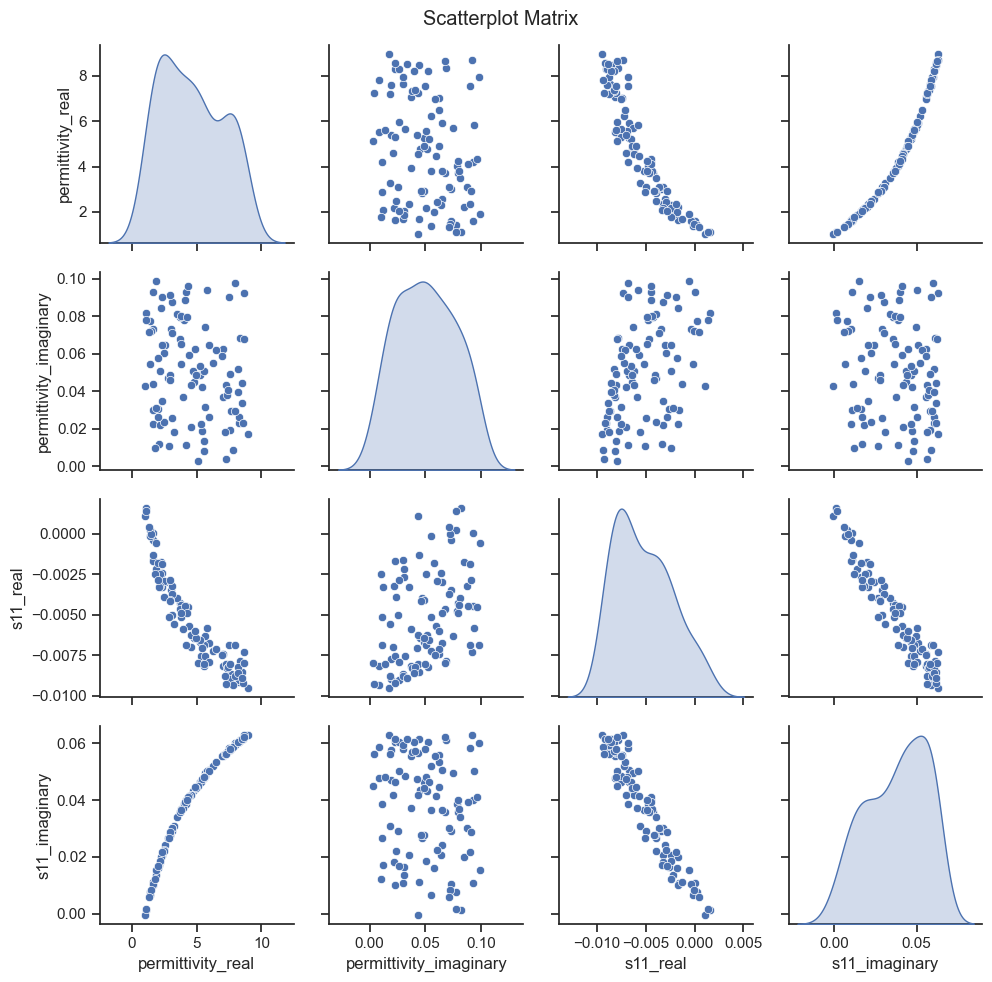

In [892]:
sns.set(style="ticks")
sns.pairplot(df[columns], diag_kind="kde")
plt.suptitle('Scatterplot Matrix')
plt.tight_layout()
plt.show()

In [893]:
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit(df[columns])
df[columns] =  X_norm.transform(df[columns])

In [894]:
X = df[['s11_real', 's11_imaginary']].values
y = df[['permittivity_real', 'permittivity_imaginary']].values

In [895]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.80 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [896]:
X_train.shape

(80, 2)

In [897]:
y_train.shape

(80, 2)

In [898]:
X_val.shape

(20, 2)

In [899]:
y_val.shape

(20, 2)

In [900]:
def mae_loss(y_true, y_pred):
    y_true_real, y_true_imag = tf.split(y_true, 2, axis=-1)
    y_pred_real, y_pred_imag = tf.split(y_pred, 2, axis=-1)
    loss_real = tf.losses.mean_absolute_error(y_true_real, y_pred_real)
    loss_imag = tf.losses.mean_absolute_error(y_true_imag, y_pred_imag)
    return loss_real + loss_imag
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])


In [901]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_245 (Dense)           (None, 128)               384       
                                                                 
 dense_246 (Dense)           (None, 64)                8256      
                                                                 
 dense_247 (Dense)           (None, 32)                2080      
                                                                 
 dense_248 (Dense)           (None, 16)                528       
                                                                 
 dense_249 (Dense)           (None, 2)                 34        
                                                                 
Total params: 11282 (44.07 KB)
Trainable params: 11282 (44.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500


80/80 [==============================] - 0s 1ms/step - loss: 0.8513 - mean_absolute_error: 0.4256 - mean_squared_error: 0.2556 - val_loss: 0.6218 - val_mean_absolute_error: 0.3109 - val_mean_squared_error: 0.1718
Epoch 2/500
80/80 [==============================] - 0s 761us/step - loss: 0.6499 - mean_absolute_error: 0.3249 - mean_squared_error: 0.1636 - val_loss: 0.4583 - val_mean_absolute_error: 0.2292 - val_mean_squared_error: 0.0981
Epoch 3/500
80/80 [==============================] - 0s 642us/step - loss: 0.4678 - mean_absolute_error: 0.2339 - mean_squared_error: 0.0899 - val_loss: 0.3813 - val_mean_absolute_error: 0.1907 - val_mean_squared_error: 0.0565
Epoch 4/500
80/80 [==============================] - 0s 635us/step - loss: 0.3517 - mean_absolute_error: 0.1758 - mean_squared_error: 0.0519 - val_loss: 0.3350 - val_mean_absolute_error: 0.1675 - val_mean_squared_error: 0.0461
Epoch 5/500
80/80 [==============================] - 0s 673us/step - loss: 0.2896 - mean_absolute_error: 0

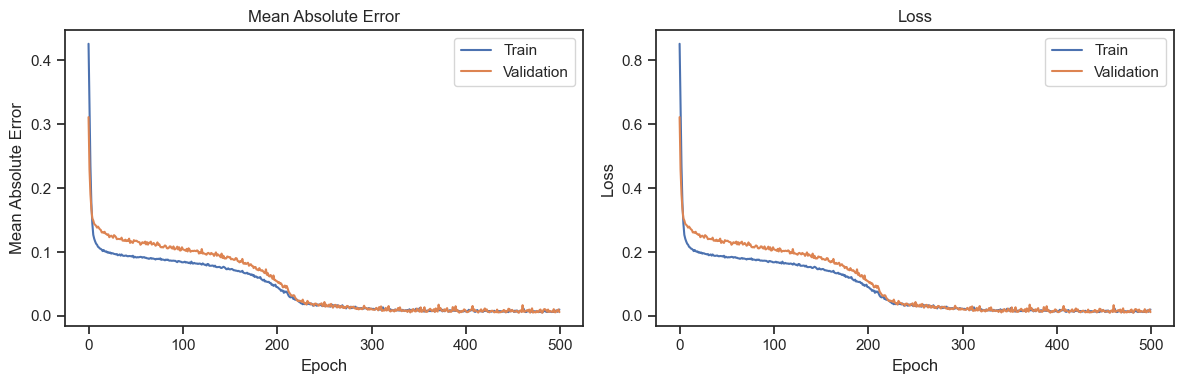

In [902]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 29ms/step


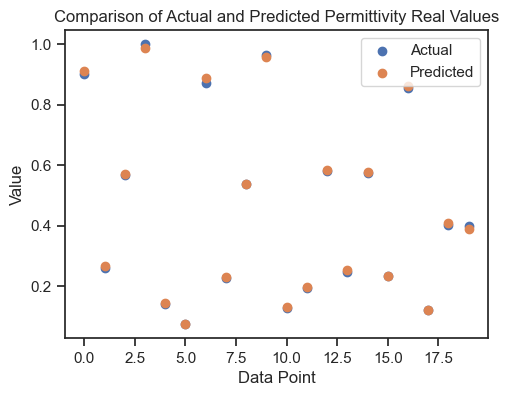

In [903]:
y_pred = model.predict(X_val)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

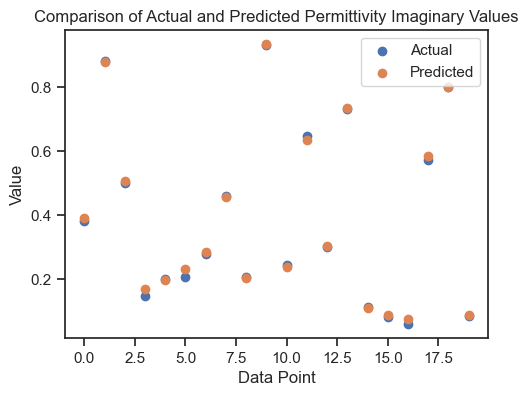

In [904]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

In [905]:
actual_matrix = np.concatenate((y_val, X_val), axis=1)
actual_matrix

array([[0.90309549, 0.38205002, 0.08239351, 0.96085748],
       [0.26055162, 0.88314178, 0.56625674, 0.48656586],
       [0.56902588, 0.49990354, 0.2369927 , 0.77025424],
       [1.        , 0.14757344, 0.        , 1.        ],
       [0.14211264, 0.20080741, 0.56653862, 0.29417597],
       [0.07417173, 0.2069795 , 0.70786938, 0.1671869 ],
       [0.87207015, 0.2789594 , 0.06473612, 0.94455189],
       [0.22626589, 0.46070161, 0.49816443, 0.4291614 ],
       [0.53828335, 0.20516203, 0.17630155, 0.74138229],
       [0.96546988, 0.93261896, 0.19726756, 0.99900686],
       [0.12843067, 0.24265769, 0.60181887, 0.27138811],
       [0.19360659, 0.64655814, 0.58702646, 0.38686334],
       [0.58000008, 0.3020125 , 0.17929536, 0.77421208],
       [0.24856229, 0.73271814, 0.54387898, 0.46732029],
       [0.57546554, 0.11194946, 0.13159896, 0.76728042],
       [0.23211858, 0.0808768 , 0.39677192, 0.42881087],
       [0.85566966, 0.0587169 , 0.01460309, 0.9327972 ],
       [0.11970212, 0.57293149,

In [906]:
predicted_matrix = np.concatenate((y_pred, X_val), axis=1)
predicted_matrix

array([[0.91276318, 0.39070821, 0.08239351, 0.96085748],
       [0.26764137, 0.88050342, 0.56625674, 0.48656586],
       [0.57164991, 0.50558925, 0.2369927 , 0.77025424],
       [0.98687488, 0.17005128, 0.        , 1.        ],
       [0.14440738, 0.19753869, 0.56653862, 0.29417597],
       [0.07658128, 0.23009892, 0.70786938, 0.1671869 ],
       [0.88699478, 0.28343529, 0.06473612, 0.94455189],
       [0.22967653, 0.45661378, 0.49816443, 0.4291614 ],
       [0.53802484, 0.20350973, 0.17630155, 0.74138229],
       [0.9594546 , 0.93490416, 0.19726756, 0.99900686],
       [0.13114019, 0.23933654, 0.60181887, 0.27138811],
       [0.19801255, 0.63623387, 0.58702646, 0.38686334],
       [0.58311987, 0.30211931, 0.17929536, 0.77421208],
       [0.25444773, 0.73551005, 0.54387898, 0.46732029],
       [0.57885766, 0.10890871, 0.13159896, 0.76728042],
       [0.23414797, 0.08626065, 0.39677192, 0.42881087],
       [0.86099595, 0.07406848, 0.01460309, 0.9327972 ],
       [0.12266117, 0.58405262,

In [907]:
actual_matrix = X_norm.inverse_transform(actual_matrix)
predicted_matrix = X_norm.inverse_transform(predicted_matrix)

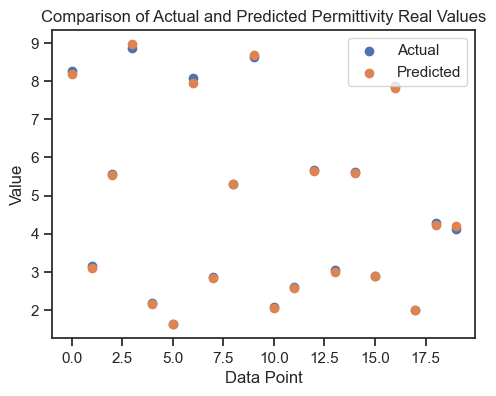

In [908]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), predicted_matrix[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), actual_matrix[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

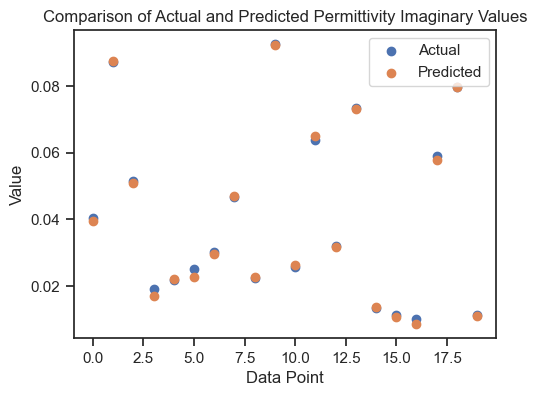

In [909]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), predicted_matrix[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), actual_matrix[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()